In [2]:
###
# Packages
###
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

###
# Packages Options
###
pd.options.mode.chained_assignment = None

In [3]:
### Inputs
season = '2020-2021'
data_dir = '%s%s%s%s' % (os.getcwd(), '\\Datas\\', season, '\\df_shots_cleaned.csv')

In [4]:
### DL of dataset
df_cleaned = pd.read_csv(data_dir)

### Small last cleaning for graph purposes
dic_shot = {0: 'missed', 1: 'made'}
df_cleaned['result_str'] = df_cleaned['result'].map(dic_shot)

In [5]:
df_cleaned.head(5)

,result,away_score,home_score,player_team_scorediff,play_length,elapsed,shot_distance,area_shot,player_home,player_away,...,shots_player_made,shots_player_total,FG_player,player_streak,assist_player_total,ratio_assist_player,Position,Experience,Age,result_str
0,1,2,2,-2,16,I_00-02,22,Long_Paint_Shot,1,0,...,0,0,0.0,0,0,0.0,PG,9,28,made
1,1,4,2,0,11,I_00-02,1,Under_the_Circle,0,1,...,0,0,0.0,0,0,0.0,C,0,19,made
2,1,4,5,-2,22,I_00-02,26,3pt_Middle,1,0,...,0,0,0.0,0,0,0.0,PF,12,32,made
3,0,4,5,-1,18,I_00-02,24,3pt_Left_Corner,0,1,...,0,0,0.0,0,0,0.0,PF,6,25,missed
4,1,4,7,1,2,I_00-02,5,Under_the_Circle,1,0,...,1,1,100.0,1,1,100.0,PF,12,32,made


In [6]:
## Graph I function : Functions to create easy-to-use dataframes serving for graph purposes 

# Creation of a sub data frame using as graph input
def category_result(df, var_selected='Position'):
    df_tmp = pd.pivot_table(data=df, index=var_selected, columns='result_str', aggfunc='size', fill_value=0)
    df_tmp['FG%'] = round(100 * df_tmp['made'] / (df_tmp['made'] + df_tmp['missed']), 2)
    return df_tmp

def category_melt(df, var_selected='Position'):
    df_tmp = category_result(df, var_selected).reset_index()
    df_tmp = pd.melt(df_tmp, id_vars=[var_selected], value_vars=['made', 'missed'], value_name='Total')
    return df_tmp

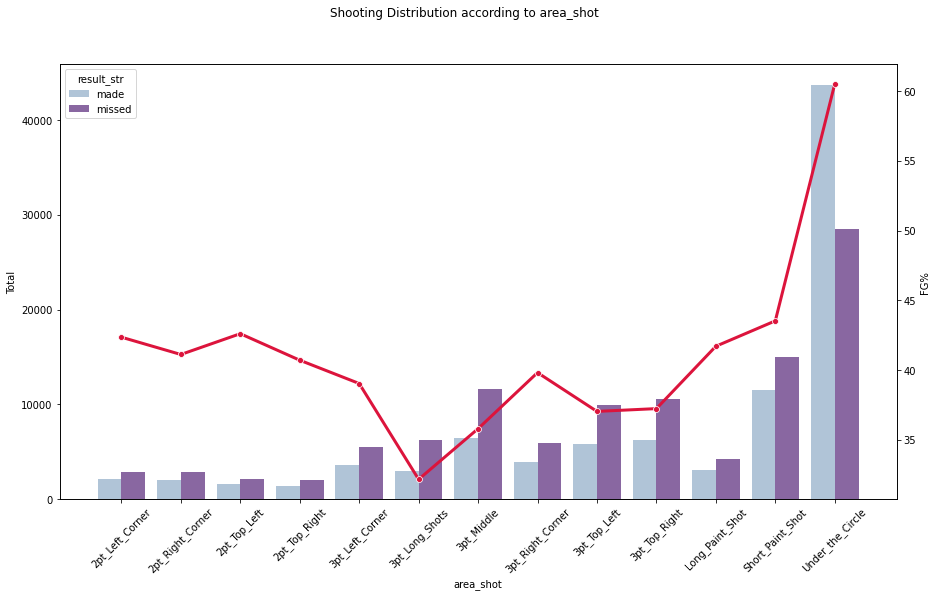

In [7]:
## Graph I : 2D-graphs with number of made, missed shots and FG% for a defined variable (input is var_selected)

# Inputs
df=df_cleaned
var_selected='area_shot'
color_palette = 'BuPu'

# Graphs
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle(f'Shooting Distribution according to {var_selected}')

# Positions
sns.barplot(data=category_melt(df, var_selected),
    x=var_selected, y='Total', ax=ax,
    hue='result_str', palette=sns.color_palette(color_palette, 2)
)
ax2 = ax.twinx()
sns.lineplot(data=category_result(df, var_selected),
    x=var_selected, y='FG%', ax=ax2, 
    marker='o', color='crimson', lw=3,
)

ax.tick_params(axis='x', labelrotation=45)

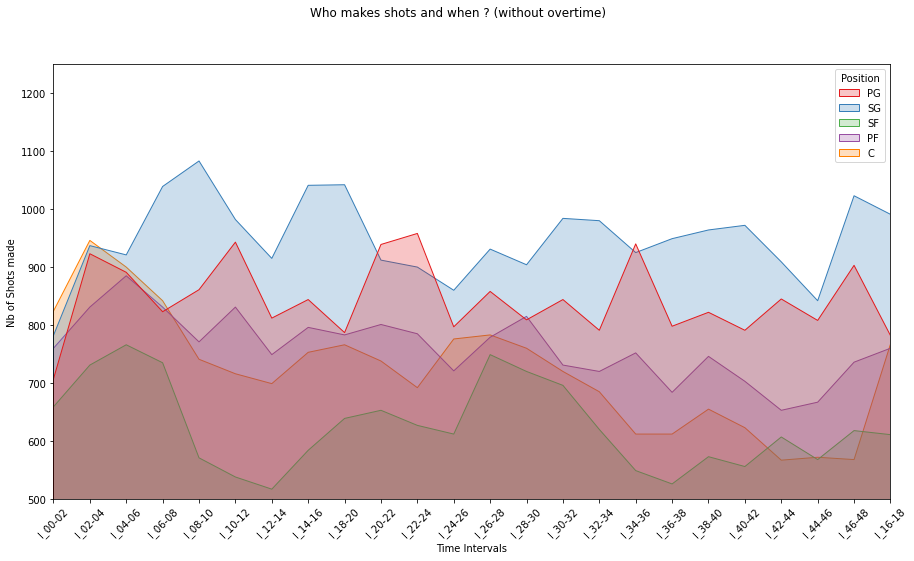

In [8]:
## Graph II : Number of shots made by positions and time intervals
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Who makes shots and when ? (without overtime)')

positions = ['PG', 'SG', 'SF', 'PF', 'C']
palette = sns.color_palette('Set1', 5)

sns.histplot(
    # x=df_cleaned.elapsed, 
    x=df_cleaned.loc[df_cleaned.result == 1, 'elapsed'],
    hue=df_cleaned.Position, hue_order=positions,  
    element='poly', 
    palette=palette
    )
ax.set_xlabel('Time Intervals')
ax.set_xlim((0, 23))
ax.set_ylabel('Nb of Shots made')
ax.set_ylim((500, 1250))
ax.tick_params(axis='x', labelrotation=45)

In [9]:
## Graph III : Tree Map to explore players' effeciency per area and by position (large rectangle: large amount of shots taken, colour represents FG%) 

# Re-shaping of data frame for graph purpose
df_for_tree = df_cleaned.pivot_table(
    values='result', 
    columns='result_str', 
    index=['Position', 'area_shot'], 
    aggfunc='count'
    ).reset_index()

df_for_tree['FG'] = round(
    100 * df_for_tree['made'] / (df_for_tree['missed'] + df_for_tree['made']), 
    2
    )

fig_treemap = px.treemap(data_frame=df_for_tree, 
           path=[px.Constant('All'), 'Position', 'area_shot'], 
           values='made',
           color='FG', color_continuous_scale='RdBu', 
           width=900, height=600, title='Analysis of players efficiencies per area'
           )

fig_treemap.data[0].hovertemplate = 'Label: %{label}<br>FG: %{color:.2f}%<br>Nb Made: %{value}'
fig_treemap.show()

<Axes: xlabel='Position', ylabel='area_shot'>

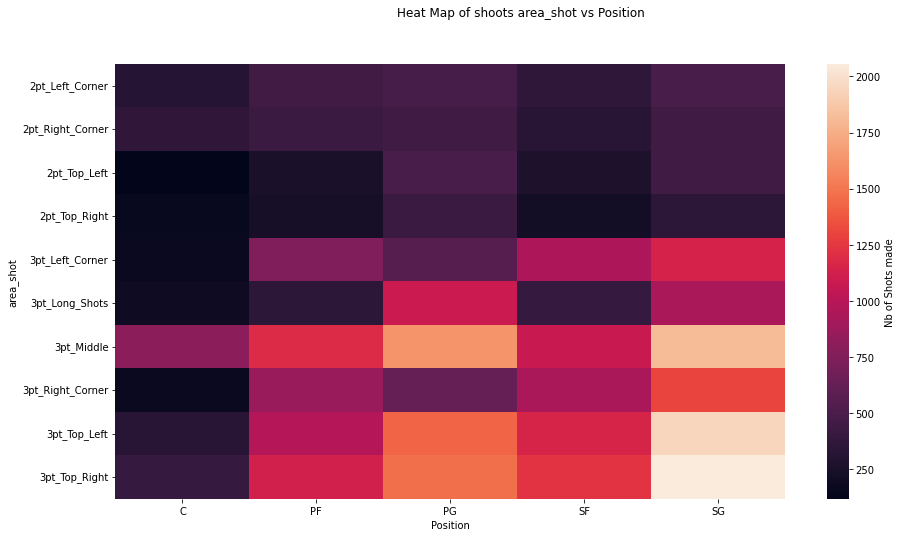

In [10]:
## Graph IV : Shooting distribution outside of the paint (per position and areas)
horiz_var='area_shot'
vert_var='Position'
shot_type='made'

plt.figure(figsize=(15, 8))
plt.suptitle(f'Heat Map of shoots {horiz_var} vs {vert_var}')

# Data re shaping for graph purpose
def pivot_result(df, vert_var='Position', horiz_var='area_shot', bucket_type='made'):
    df_tmp = df.query('result_str == @bucket_type')
    df_tmp = pd.pivot_table(df_tmp,
        index=[horiz_var], columns=[vert_var],
        aggfunc='size', fill_value=0
    )
    return df_tmp

# Correlation graph representation
sns.heatmap(
    data=pivot_result(df_cleaned.query('area_shot.str.contains("2|3")'),
        vert_var=vert_var, horiz_var=horiz_var, bucket_type=shot_type
    ), cbar_kws = {'label': f'Nb of Shots {shot_type}'}
)